In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.lstm_forecasting import LSTMTimeSeries
from src.xgb_forecasting import XGBoostModel
from sklearn.metrics import mean_squared_error
from src.preprocess import *
from src.add_features import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
# convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [3]:
# champs_elysees_df.isna().sum()/champs_elysees_df["Identifiant arc"].count()

In [4]:
df_champs_lstm=pipeline(champs_elysees_df, window=3, fill_hours=True)
df_champs_xgb = pipeline(champs_elysees_df,window=3,fill_hours=False)

# XGBoost model

In [5]:
from src.xgb_forecasting import XGBoostModel

Train set: (8387, 25), Test set: (72, 25) (72 hours)
Débit horaire : RMSE = 96.60, Mean = 779.03, Relative Error = 12.40%
Taux d'occupation : RMSE = 4.54, Mean = 17.27, Relative Error = 26.26%


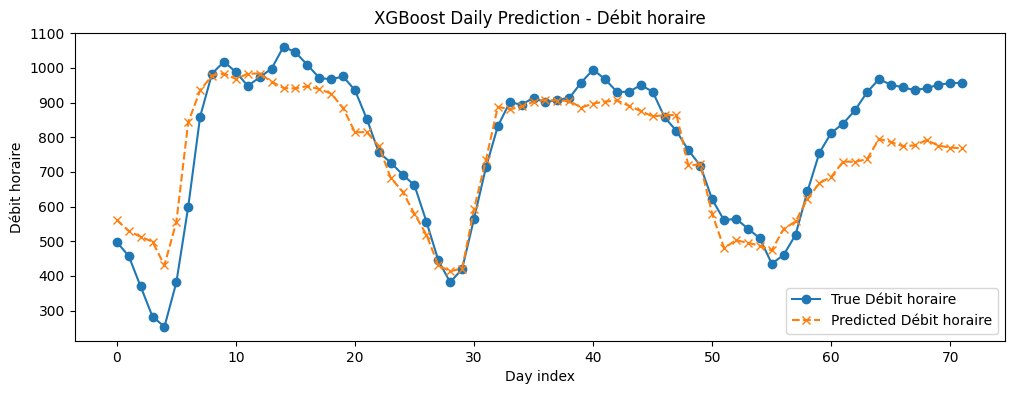

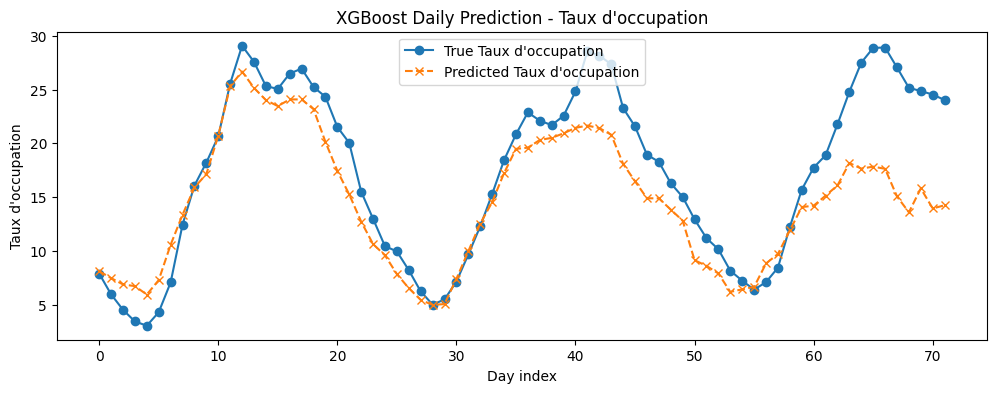

In [7]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb = df_champs_xgb.copy()

# Lags à créer (en heures)
lags_hours = [72,168]  # 1h, 3h, 1 jour, 2 jours, 1 semaine

for target in targets:
    for lag in lags_hours:
        col_name = f"{target}_lag_{lag}h"
        df_xgb[col_name] = df_xgb[target].shift(lag)
        features_xgb.append(col_name)

# Supprimer les lignes contenant des NaN générés par les lags
df_xgb = df_xgb.dropna(subset=[f"{t}_lag_{lag}h" for t in targets for lag in lags_hours] + targets).copy()


xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}",marker='o')
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}",marker="x")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [9]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 167.41, std = 35.95 | MAE mean = 124.34, std = 31.77 | MAPE mean = 59.68%, std = 68.47%
Taux d'occupation : CV RMSE mean = 4.74, std = 1.09 | MAE mean = 3.29, std = 0.68 | MAPE mean = 34.77%, std = 13.51%


# LSTM Time series

In [7]:
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

targets = ['Débit horaire', "Taux d'occupation"]

features = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]


In [8]:
final_eval_size = 72
seq_length = 168

# On garde les 168h avant la période finale pour le contexte
context_start = -(seq_length + final_eval_size)
context_end = -final_eval_size

train_val_df = df_champs_lstm.iloc[:-final_eval_size].copy()   # tout ce qui est AVANT le contexte
#context_df = df_champs.iloc[context_start:context_end].copy()  # les 168h de contexte
final_eval_df = df_champs_lstm.iloc[-final_eval_size:].copy()       # les 72h à prédire

print(f"Train: {train_val_df.shape},  Eval: {final_eval_df.shape}")

lstm_model = LSTMTimeSeries(
    features=features,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

Train: (9453, 53),  Eval: (72, 53)


In [11]:
df_champs_orig=pipeline(champs_elysees_df, window=0, fill_hours=True)
df_or = df_champs_orig.iloc[:-final_eval_size].copy()
lstm_model.cross_validate(train_val_df,epochs=30,batch_size=32)

8627
9525
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step

===== Fold 1 =====
Débit horaire             RMSE: 219.52, MEAN: 703.67, MAPE: 245.97%, RMSE/mean: 31.20%
Taux d'occupation         RMSE: 7.93, MEAN: 15.46, MAPE: 54.47%, RMSE/mean: 51.34%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

===== Fold 2 =====
Débit horaire             RMSE: 191.53, MEAN: 782.97, MAPE: 29.94%, RMSE/mean: 24.46%
Taux d'occupation         RMSE: 4.17, MEAN: 13.90, MAPE: 27.40%, RMSE/mean: 30.02%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

===== Fold 3 =====
Débit horaire             RMSE: 204.10, MEAN: 745.76, MAPE: 48.88%, RMSE/mean: 27.37%
Taux d'occupation         RMSE: 5.31, MEAN: 15.46, MAPE: 59.58%, RMSE/mean: 34.37%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

===== Fold 4 =====
Débit horaire             RMSE: 191.59, MEAN: 730.33, MAPE: 31.95%, RMSE/mean: 26.23%
Taux d'occupation         RMSE: 7.49, MEAN: 17.36, MAPE: 50.86%, RMSE/mean: 43.12%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

===== Fold 5 =====
Débit horaire

In [12]:
lstm_model.train_final(train_val_df, epochs=30, batch_size=32)

Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - loss: 0.5663 - mae: 0.5500 - mape: 230.7475
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 0.3986 - mae: 0.4477 - mape: 240.9895
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - loss: 0.3155 - mae: 0.3967 - mape: 213.2770
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.2708 - mae: 0.3683 - mape: 199.9879
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 0.2410 - mae: 0.3475 - mape: 190.2085
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 0.2260 - mae: 0.3354 - mape: 183.4504
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - loss: 0.2040 - mae: 0.3197 - mape: 176.3489
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 0.2197 - mae: 0.3314 - mape: 185.2548
Epoch 9/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.1996 - mae: 0.3182 - mape: 179.5509
Epoch 10/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - loss: 0.1854 - mae: 0.3069 - mape: 173.1474

In [13]:
y_pred = lstm_model.predict(train_val_df[-168:])  # entrée : les 168 dernières heures avant la période finale

print("\n📊 Évaluation finale par target :")
for i, target_name in enumerate(targets):
    y_true_i = final_eval_df[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

📊 Évaluation finale par target :
Débit horaire             RMSE: 95.42, MEAN: 779.03, MAPE: 12.44%, RMSE/mean: 12.25%
Taux d'occupation         RMSE: 3.11, MEAN: 17.27, MAPE: 19.87%, RMSE/mean: 18.01%


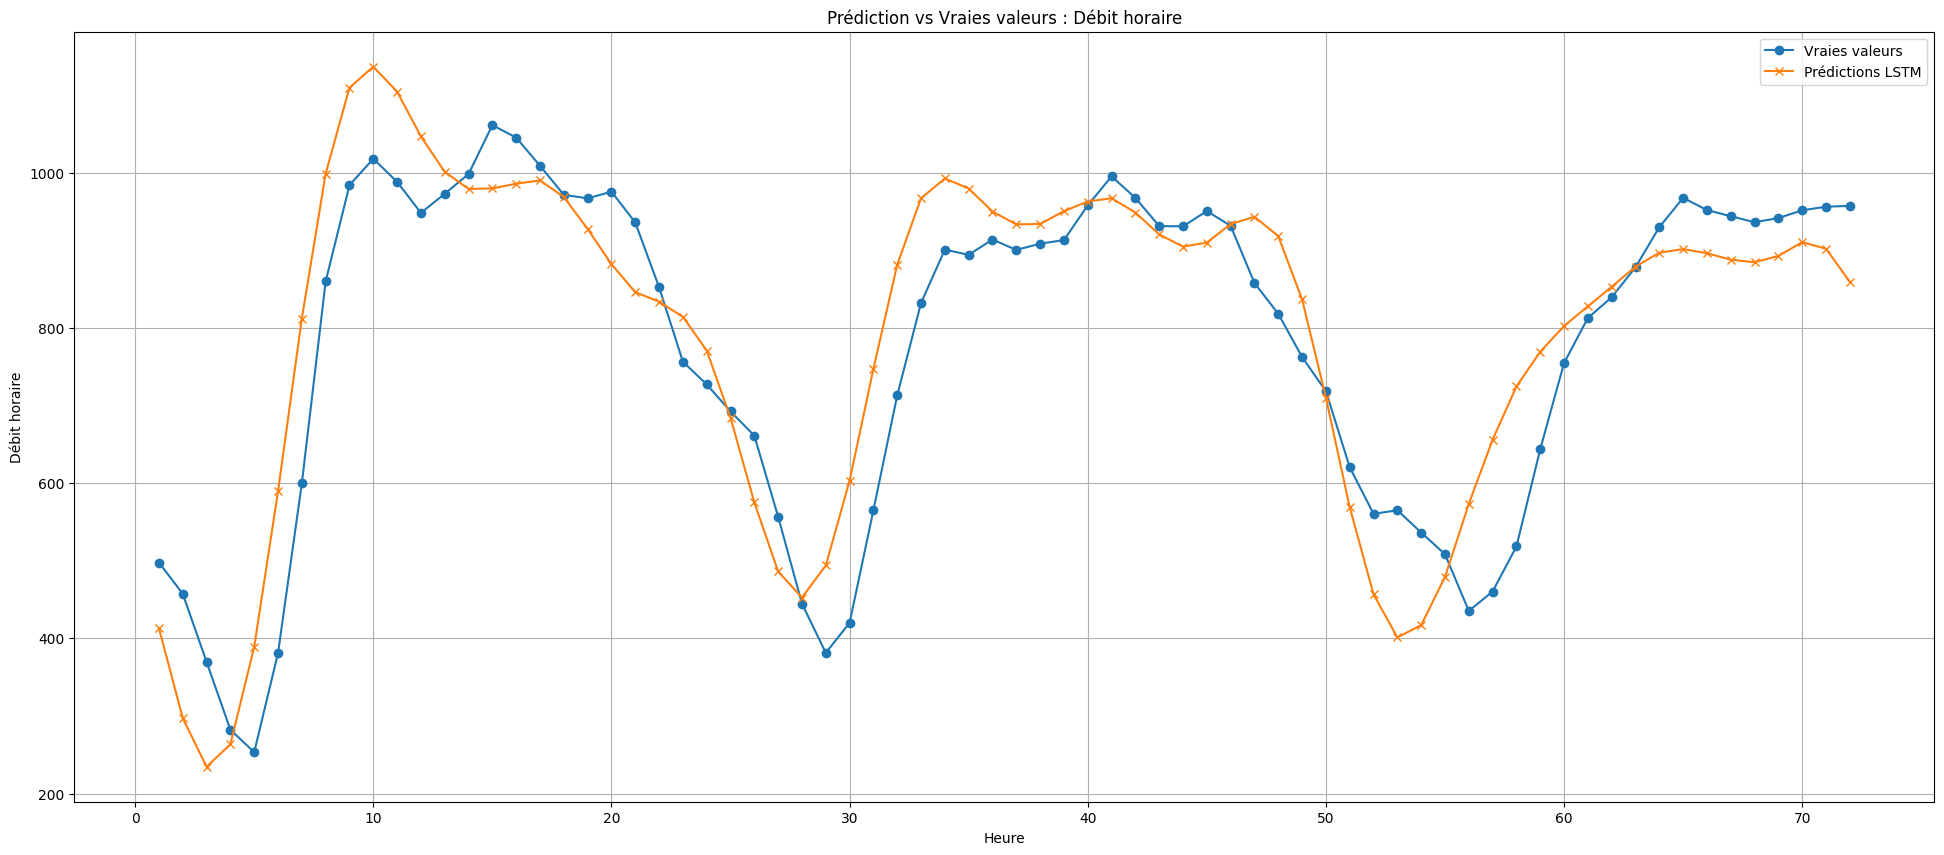

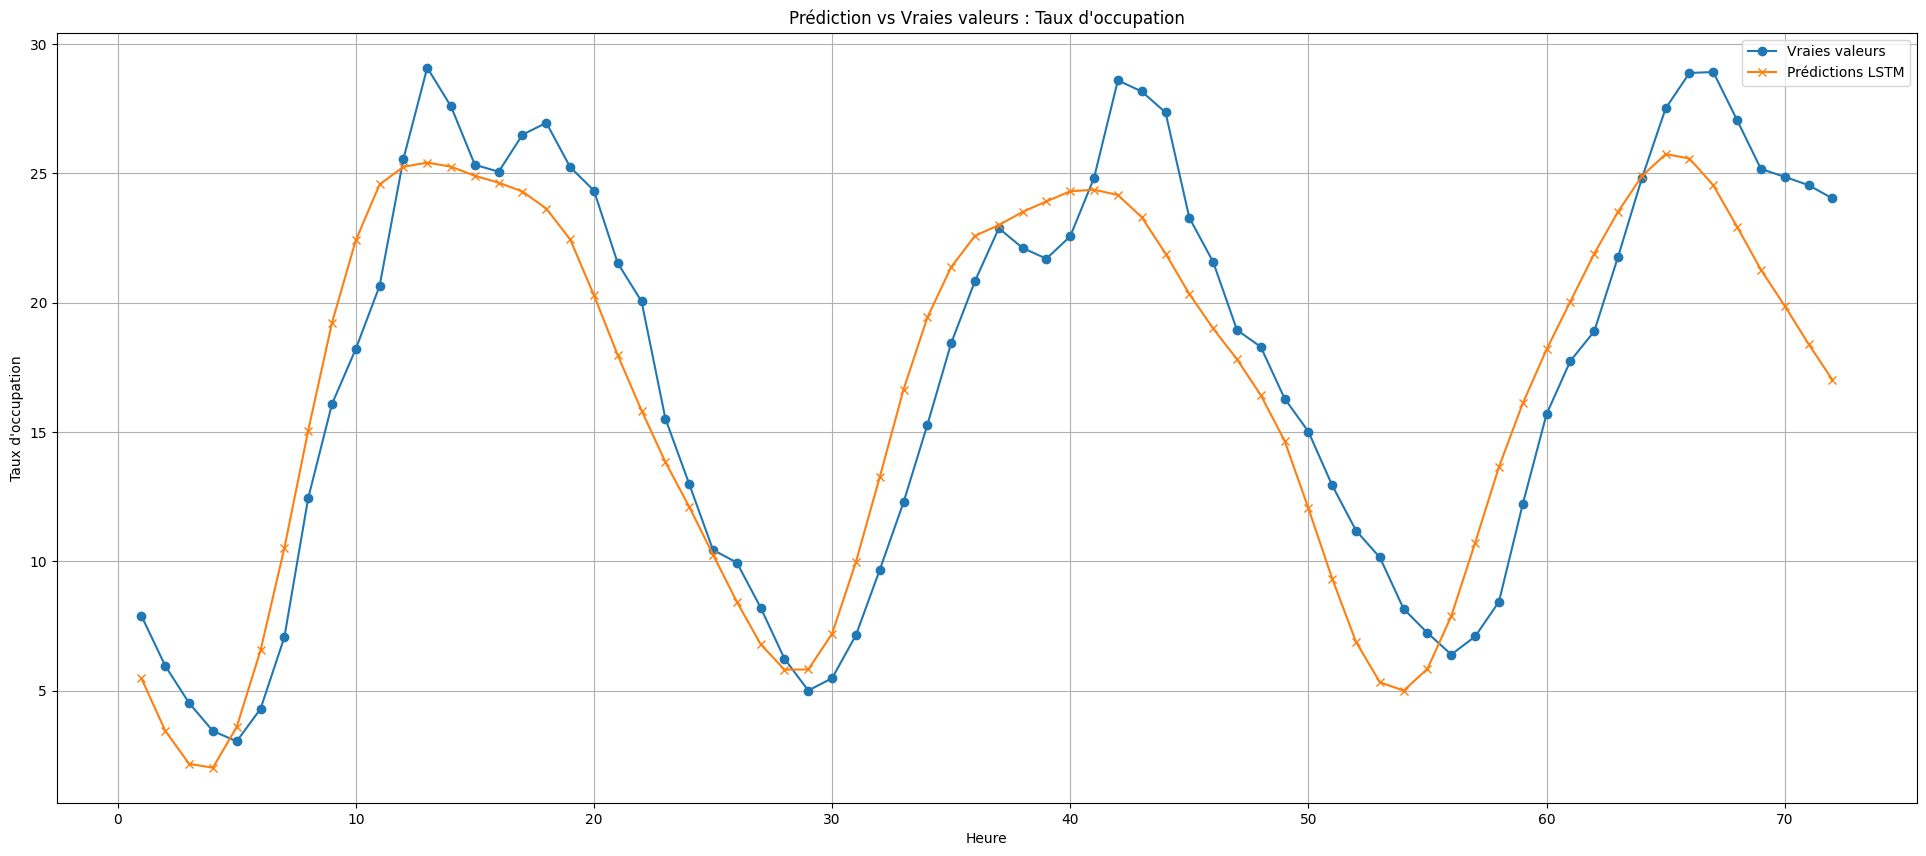

In [14]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()


In [15]:
df_champs_orig=pipeline(champs_elysees_df, window=0, fill_hours=True)
df_champs_orig_last = df_champs_orig.iloc[-72:,:]
print("\n📊 Évaluation finale par target (sans fuite de données) :")
for i, target_name in enumerate(targets):
    y_true_i = df_champs_orig_last[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

8627
9525

📊 Évaluation finale par target (sans fuite de données) :
Débit horaire             RMSE: 108.88, MEAN: 779.11, MAPE: 15.11%, RMSE/mean: 13.98%
Taux d'occupation         RMSE: 3.62, MEAN: 17.25, MAPE: 22.83%, RMSE/mean: 21.00%


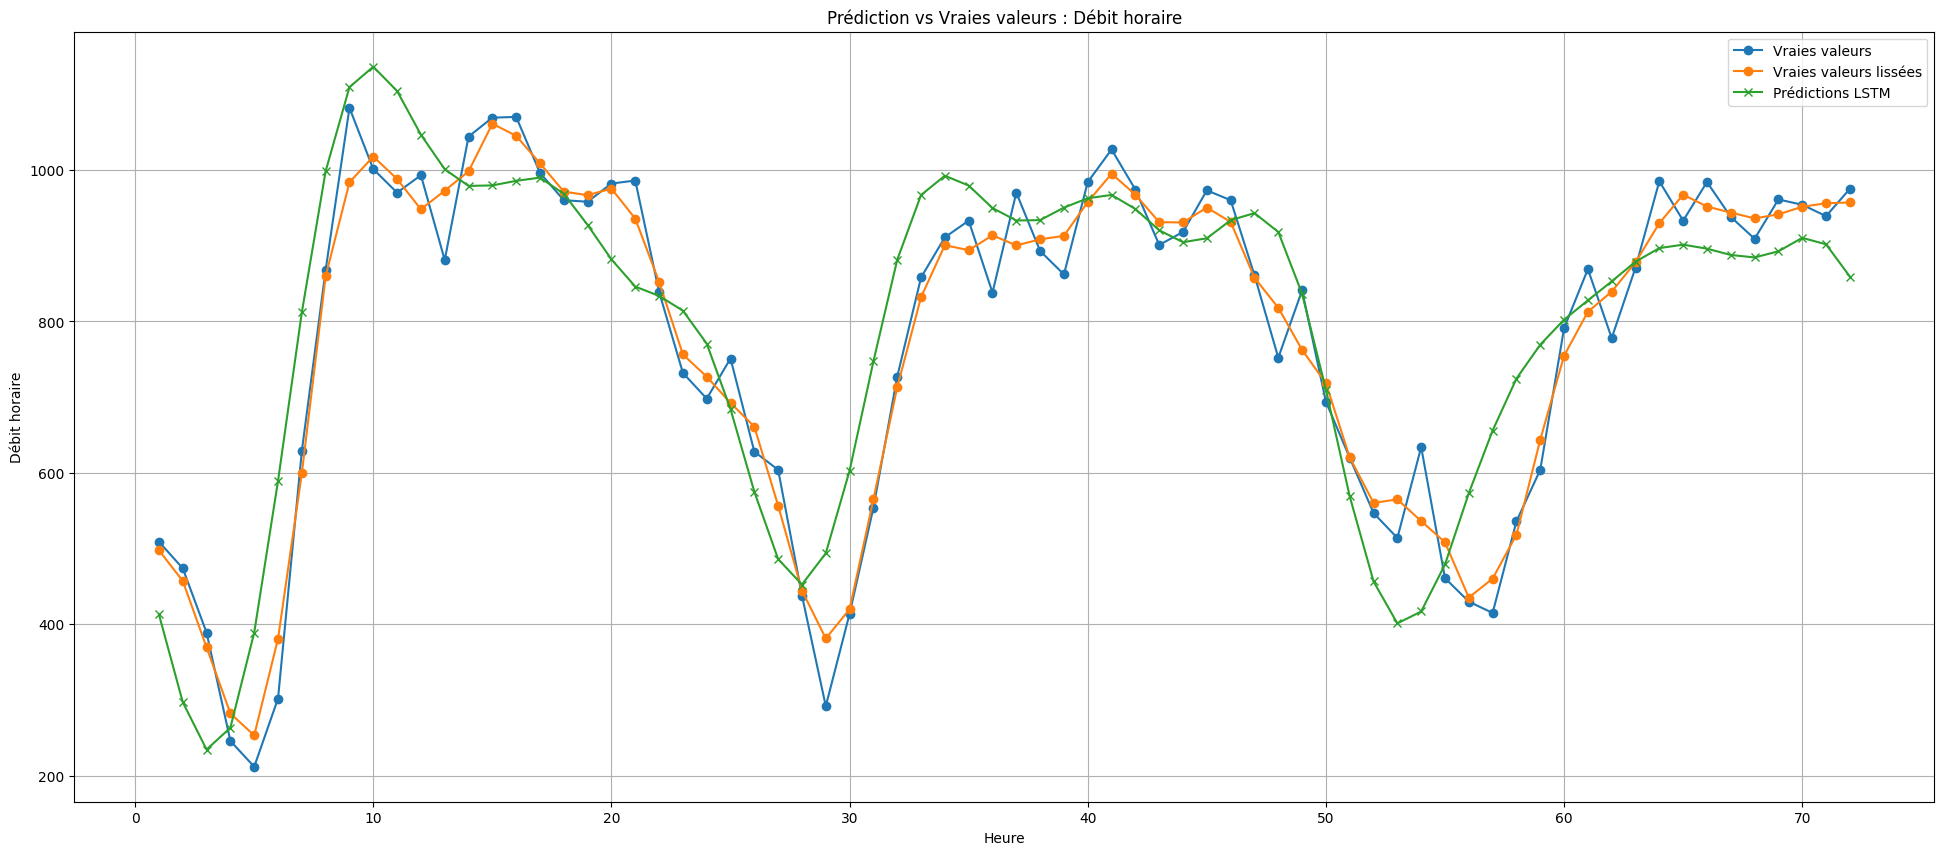

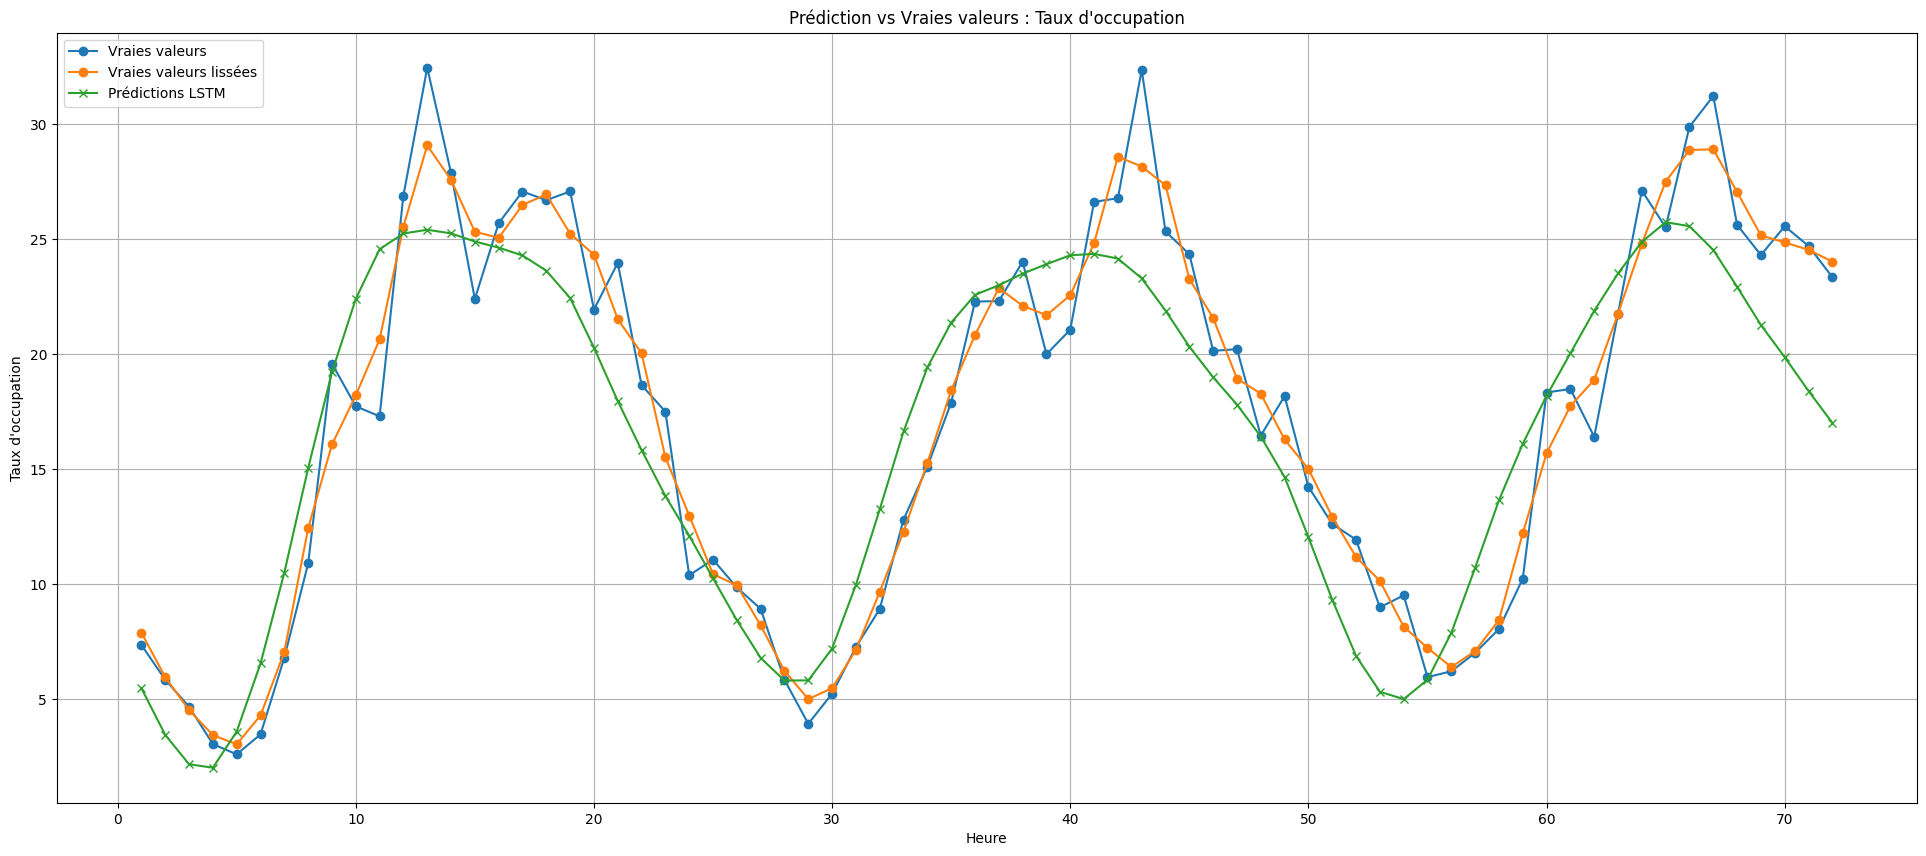

In [16]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, df_champs_orig_last[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs lissées')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()